In [77]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from bs4 import BeautifulSoup
questions = pd.read_csv('../data/Questions.csv', encoding = "ISO-8859-1")
answers = pd.read_csv('../data/Answers.csv', encoding = "ISO-8859-1")
tags = pd.read_csv('../data/Tags.csv', encoding = "ISO-8859-1")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sruthi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sruthi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sruthi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [137]:
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [138]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [139]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [140]:
combined = questions.merge(answers, left_on=['OwnerUserId','Id'], right_on = ['OwnerUserId','ParentId'], how='inner')

In [141]:
combined = combined.rename(columns = {'Id_x': 'Id',
                           'CreationDate_x': 'QuestionCreationDate', 
                           'Score_x': 'QuestionScore', 
                           'Body_x': 'QuestionBody', 
                           'CreationDate_y': 'AnswerCreationDate', 'Score_y': 'AnswerScore', 'Body_y': 'AnswerBody'})
# combined = combined.drop(['Id_y', 'ParentId'], axis = 1)

combined.drop(columns=['OwnerUserId', 'QuestionCreationDate', 'ClosedDate', 'AnswerCreationDate', 'Id_y', 'ParentId'], inplace=True)
combined.head()

,Id,QuestionScore,Title,QuestionBody,AnswerScore,AnswerBody
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,12,<p>I wound up using this. It is a kind of a ha...
1,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,4,"<p>Yes, I thought about that, but I soon figur..."
2,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,0,<p>I'm partway to my solution with this entry ...
3,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,0,"<p>Despite what the <a href=""http://msdn.micro..."
4,1160,36,Use SVN Revision to label build in CCNET,<p>I am using CCNET on a sample project with S...,3,"<p>I found <a href=""http://code.google.com/p/s..."


In [142]:
#grouped tags with similar id in tag_df
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags

Id
80                                 flex actionscript-3 air
90            svn tortoisesvn branch branching-and-merging
120                                    sql asp.net sitemap
180         algorithm language-agnostic colors color-space
260                c# .net scripting compiler-construction
                                 ...                      
40143210                                     php .htaccess
40143300                                   google-bigquery
40143340                            android android-studio
40143360                                 javascript vue.js
40143380                                   npm mocha babel
Name: Tag, Length: 1264216, dtype: object

In [143]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [144]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [145]:
combined = combined.merge(grouped_tags_final, on='Id')
combined

,Id,QuestionScore,Title,QuestionBody,AnswerScore,AnswerBody,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,12,<p>I wound up using this. It is a kind of a ha...,flex actionscript-3 air
1,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,4,"<p>Yes, I thought about that, but I soon figur...",c# .net scripting compiler-construction
2,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,0,<p>I'm partway to my solution with this entry ...,windows visual-studio registry installation
3,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,0,"<p>Despite what the <a href=""http://msdn.micro...",windows visual-studio registry installation
4,1160,36,Use SVN Revision to label build in CCNET,<p>I am using CCNET on a sample project with S...,3,"<p>I found <a href=""http://code.google.com/p/s...",svn msbuild cruisecontrol.net
...,...,...,...,...,...,...,...
130020,40142220,0,Setting up Derby on MacOS Sierra,<p>I am following Java: How To Program - Chapt...,0,<p>I figured the problem was. When the creatin...,java derby macos-sierra
130021,40142310,0,Get multiple cursors (carets) at each find res...,<p>I want to select all the string resource ke...,1,"<p>Intellij Idea calls this <a href=""https://w...",android-studio intellij-idea
130022,40142360,0,Cannot find module `dist/bin/x.js` when trying...,<p>You did <code>npm install -g aVeryCoolPacka...,0,<p>In my case I had cloned the repo from githu...,node.js command-line npm npm-install
130023,40142470,0,d3 chart and google font not visible on github...,"<p>I uploaded a page onto Github and the HTML,...",0,<p>OOOOPS \nFound the clue and (incomplete) an...,jquery d3.js github github-pages google-font-api


In [146]:
combined.isna().sum()

Id               0
QuestionScore    0
Title            0
QuestionBody     0
AnswerScore      0
AnswerBody       0
Tags             0
dtype: int64

Text(0.5, 1.0, 'Ratio of missing values per columns')

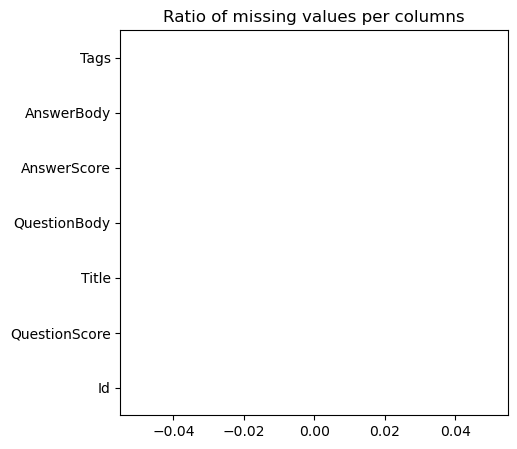

In [147]:

plt.figure(figsize=(5, 5))
combined.isna().sum().plot.barh()
plt.title("Ratio of missing values per columns")

In [148]:
print('Dupplicate entries: {}'.format(combined.duplicated().sum()))
combined.drop_duplicates(inplace = True)

Dupplicate entries: 1


In [149]:
#now we filter as per the scores
print(f"Minimum Score: {combined['QuestionScore'].min()}")
print(f"Maximum Score: {combined['QuestionScore'].max()}")
#deleting queries with score less than 5
new_question_df = combined[combined['QuestionScore'] > 3]
new_question_df

Minimum Score: -13
Maximum Score: 1412


,Id,QuestionScore,Title,QuestionBody,AnswerScore,AnswerBody,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,12,<p>I wound up using this. It is a kind of a ha...,flex actionscript-3 air
1,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,4,"<p>Yes, I thought about that, but I soon figur...",c# .net scripting compiler-construction
2,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,0,<p>I'm partway to my solution with this entry ...,windows visual-studio registry installation
3,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,0,"<p>Despite what the <a href=""http://msdn.micro...",windows visual-studio registry installation
4,1160,36,Use SVN Revision to label build in CCNET,<p>I am using CCNET on a sample project with S...,3,"<p>I found <a href=""http://code.google.com/p/s...",svn msbuild cruisecontrol.net
...,...,...,...,...,...,...,...
129721,40038580,4,Find the last visited URL in javascript with h...,<p>I know about <code>document.referer</code> ...,0,<p>So my problem was that there is no option f...,javascript
129738,40042330,4,Calculating a definite integral results in a r...,<p>I am trying to calculate the percentage of ...,0,<p>For some reason Matlab while was able to ev...,matlab symbolic-math
129819,40073530,16,Why doesn't ${@:-1} return the last element of...,<p><em>I thought to post up a Q&amp;A on this ...,19,<h3><code>${parameter:-word}</code> is a type ...,bash
129897,40101130,4,how do I calculate a rolling idxmax,<p>consider the <code>pd.Series</code> <code>s...,3,<p>I used a generator</p>\n\n<pre><code>def id...,python pandas numpy dataframe series


In [150]:
new_question_df.drop(columns=['Id', 'QuestionScore','AnswerScore'], inplace=True)
new_question_df

/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/3710370792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df.drop(columns=['Id', 'QuestionScore','AnswerScore'], inplace=True)


,Title,QuestionBody,AnswerBody,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,<p>I wound up using this. It is a kind of a ha...,flex actionscript-3 air
1,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"<p>Yes, I thought about that, but I soon figur...",c# .net scripting compiler-construction
2,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,<p>I'm partway to my solution with this entry ...,windows visual-studio registry installation
3,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,"<p>Despite what the <a href=""http://msdn.micro...",windows visual-studio registry installation
4,Use SVN Revision to label build in CCNET,<p>I am using CCNET on a sample project with S...,"<p>I found <a href=""http://code.google.com/p/s...",svn msbuild cruisecontrol.net
...,...,...,...,...
129721,Find the last visited URL in javascript with h...,<p>I know about <code>document.referer</code> ...,<p>So my problem was that there is no option f...,javascript
129738,Calculating a definite integral results in a r...,<p>I am trying to calculate the percentage of ...,<p>For some reason Matlab while was able to ev...,matlab symbolic-math
129819,Why doesn't ${@:-1} return the last element of...,<p><em>I thought to post up a Q&amp;A on this ...,<h3><code>${parameter:-word}</code> is a type ...,bash
129897,how do I calculate a rolling idxmax,<p>consider the <code>pd.Series</code> <code>s...,<p>I used a generator</p>\n\n<pre><code>def id...,python pandas numpy dataframe series


In [151]:
new_question_df['Tags'] = new_question_df['Tags'].apply(lambda x: x.split())
print(new_question_df)
unique_tags = list(set([item for sublist in new_question_df['Tags'].values for item in sublist]))

len(unique_tags)

                                                    Title  \
0       SQLStatement.execute() - multiple queries in o...   
1       Adding scripting functionality to .NET applica...   
2       Visual Studio Setup Project - Per User Registr...   
3       Visual Studio Setup Project - Per User Registr...   
4                Use SVN Revision to label build in CCNET   
...                                                   ...   
129721  Find the last visited URL in javascript with h...   
129738  Calculating a definite integral results in a r...   
129819  Why doesn't ${@:-1} return the last element of...   
129897                how do I calculate a rolling idxmax   
129965  CMFCMenuButton not properly repainting when to...   

                                             QuestionBody  \
0       <p>I've written a database generation script i...   
1       <p>I have a little game written in C#. It uses...   
2       <p>I'm trying to maintain a Setup Project in <...   
3       <p>I'm trying t

/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/1713968732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['Tags'] = new_question_df['Tags'].apply(lambda x: x.split())


7840

In [152]:
flat_list = [item for sublist in new_question_df['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
keywords = nltk.FreqDist(keywords)
sum(keywords.values())

46477

In [153]:
flat_list = [item for sublist in new_question_df['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]
tags_features

['c#',
 'android',
 'java',
 'javascript',
 'python',
 'ios',
 'c++',
 'php',
 'jquery',
 '.net',
 'objective-c',
 'iphone',
 'ruby-on-rails',
 'asp.net',
 'css',
 'html',
 'ruby',
 'asp.net-mvc',
 'xcode',
 'node.js',
 'django',
 'r',
 'sql',
 'angularjs',
 'c',
 'mysql',
 'windows',
 'osx',
 'visual-studio',
 'git',
 'linux',
 'wpf',
 'spring',
 'eclipse',
 'json',
 'sql-server',
 'xml',
 'ajax',
 'swift',
 'unit-testing',
 'visual-studio-2010',
 'scala',
 'entity-framework',
 'algorithm',
 'performance',
 'html5',
 'delphi',
 'regex',
 'debugging',
 'facebook',
 'database',
 'ruby-on-rails-3',
 'hibernate',
 'qt',
 'maven',
 'winforms',
 'haskell',
 'cocoa-touch',
 'oracle',
 'mongodb',
 'cordova',
 'postgresql',
 'string',
 'wcf',
 'bash',
 'multithreading',
 'cocoa',
 'c++11',
 'ubuntu',
 'arrays',
 'rest',
 'image',
 'http',
 'twitter-bootstrap',
 'apache',
 'android-studio',
 'visual-studio-2012',
 'google-chrome',
 'uitableview',
 'ipad',
 'ssl',
 'azure',
 'spring-mvc',
 'fire

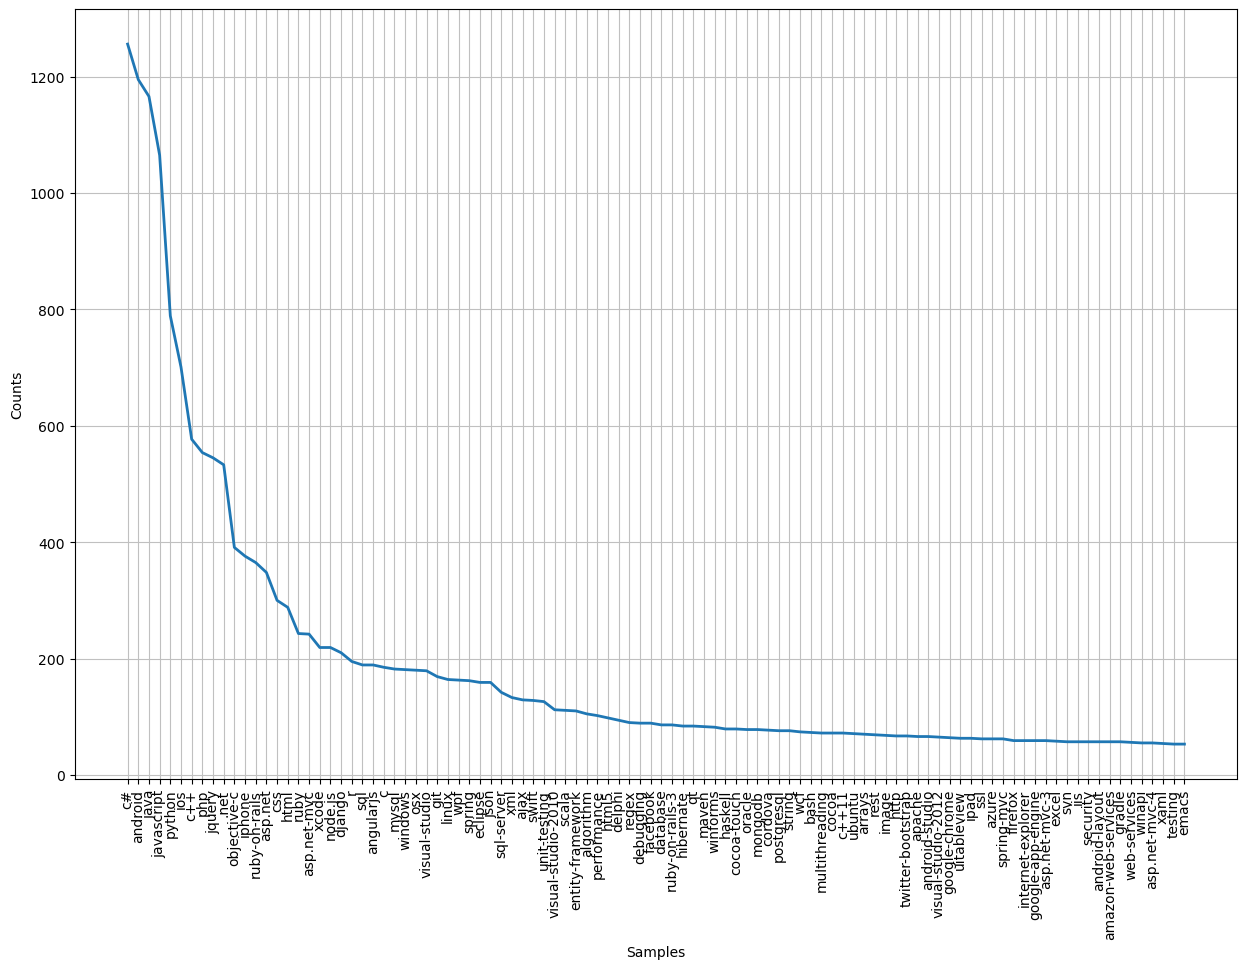

<Axes: xlabel='Samples', ylabel='Counts'>

In [154]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [155]:
def most_common(tags):
    tags_filtered = []
    for i in range(len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [156]:
new_question_df['Tags'] = new_question_df['Tags'].apply(lambda x: most_common(x))
new_question_df['Tags'] = new_question_df['Tags'].apply(lambda x: x if len(x) > 0 else None)
new_question_df.dropna(subset=['Tags'], inplace=True)
new_question_df

/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/3223676313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['Tags'] = new_question_df['Tags'].apply(lambda x: most_common(x))
/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/3223676313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['Tags'] = new_question_df['Tags'].apply(lambda x: x if len(x) > 0 else None)
/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/3223676313.py:3:

,Title,QuestionBody,AnswerBody,Tags
1,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"<p>Yes, I thought about that, but I soon figur...","[c#, .net]"
2,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,<p>I'm partway to my solution with this entry ...,"[windows, visual-studio]"
3,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,"<p>Despite what the <a href=""http://msdn.micro...","[windows, visual-studio]"
4,Use SVN Revision to label build in CCNET,<p>I am using CCNET on a sample project with S...,"<p>I found <a href=""http://code.google.com/p/s...",[svn]
5,Use SVN Revision to label build in CCNET,<p>I am using CCNET on a sample project with S...,<blockquote>\r\n <p><strong>Customizing cspro...,[svn]
...,...,...,...,...
129540,Upload file to MS SharePoint using Python OneD...,<p>Is it possible to upload a file to the <str...,"<p>I finally found a solution, with the help o...",[python]
129721,Find the last visited URL in javascript with h...,<p>I know about <code>document.referer</code> ...,<p>So my problem was that there is no option f...,[javascript]
129819,Why doesn't ${@:-1} return the last element of...,<p><em>I thought to post up a Q&amp;A on this ...,<h3><code>${parameter:-word}</code> is a type ...,[bash]
129897,how do I calculate a rolling idxmax,<p>consider the <code>pd.Series</code> <code>s...,<p>I used a generator</p>\n\n<pre><code>def id...,[python]


Text processing:

Removing html format

Lowering text

Transforming abbreviations

Removing punctuation (but keeping words like c# since it's the most popular tag)

Lemmatizing words

Removing stop words

In [157]:
# Converting html to text in the body
new_question_df['QuestionBody'] = [BeautifulSoup(text).get_text() for text in new_question_df['QuestionBody'] ]
new_question_df['AnswerBody'] = [BeautifulSoup(text).get_text() for text in new_question_df['AnswerBody'] ]
# new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: BeautifulSoup(x).get_text()) 

/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/159080464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['QuestionBody'] = [BeautifulSoup(text).get_text() for text in new_question_df['QuestionBody'] ]
/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/159080464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['AnswerBody'] = [BeautifulSoup(text).get_text() for text in new_question_df['AnswerBody'] ]


In [158]:
def clean_text(text):
    text = text.lower()
    text = text.strip(' ')
    return text

token = ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text): 
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
    filtered_list = strip_list_noempty(punctuation_filtered)
    return ' '.join(map(str, filtered_list))
def lemmatizeWords(text):
    words = token.tokenize(text)
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [159]:
# Remove stopwords, punctuation and lemmatize for text in body
new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: clean_text(x)) 
new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: clean_punct(x)) 
new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: lemmatizeWords(x))
new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: stopWordsRemove(x))

# Remove stopwords, punctuation and lemmatize for text in body
new_question_df['AnswerBody'] = new_question_df['AnswerBody'].apply(lambda x: clean_text(x)) 
new_question_df['AnswerBody'] = new_question_df['AnswerBody'].apply(lambda x: clean_punct(x)) 
new_question_df['AnswerBody'] = new_question_df['AnswerBody'].apply(lambda x: lemmatizeWords(x))
new_question_df['AnswerBody'] = new_question_df['AnswerBody'].apply(lambda x: stopWordsRemove(x))

# Remove stopwords, punctuation and lemmatize for title.
new_question_df['Title'] = new_question_df['Title'].apply(lambda x: str(x))
new_question_df['Title'] = new_question_df['Title'].apply(lambda x: clean_text(x)) 
new_question_df['Title'] = new_question_df['Title'].apply(lambda x: clean_punct(x)) 
new_question_df['Title'] = new_question_df['Title'].apply(lambda x: lemmatizeWords(x)) 
new_question_df['Title'] = new_question_df['Title'].apply(lambda x: stopWordsRemove(x))

/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/2683010930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: clean_text(x))
/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/2683010930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['QuestionBody'] = new_question_df['QuestionBody'].apply(lambda x: clean_punct(x))
/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63

In [160]:
#data is finally cleaned and preprocessed
new_question_df

,Title,QuestionBody,AnswerBody,Tags
1,add script functionality .net applications,little game write c use database back-end trad...,yes think soon figure another domain-specific-...,"[c#, .net]"
2,visual studio setup project - per user registr...,try maintain setup project visual studio 2003 ...,partway solution entry msdn know find usermach...,"[windows, visual-studio]"
3,visual studio setup project - per user registr...,try maintain setup project visual studio 2003 ...,despite msdn article say usermachine hive writ...,"[windows, visual-studio]"
4,use svn revision label build ccnet,use ccnet sample project svn source control cc...,find project google code ccnet plugin generate...,[svn]
5,use svn revision label build ccnet,use ccnet sample project svn source control cc...,customize csproj file autogenerate assemblyinf...,[svn]
...,...,...,...,...
129540,upload file ms sharepoint use python onedrive sdk,possible upload file share document library mi...,finally find solution help user sytech answer ...,[python]
129721,find last visit url javascript history,know documentreferer look could probably solut...,problem option purpose local without server en...,[javascript]
129819,-1 return last element,think post qa find anything similar already ex...,parameter -word type parameter expansion param...,[bash]
129897,calculate roll idxmax,consider pdseries import pandas pd import nump...,use generator def idxmax w 0 w len yield siloc...,[python]


In [165]:
new_question_df['Combined_text'] = new_question_df['Title'] + ' ' + new_question_df['QuestionBody'] + ' ' +new_question_df['AnswerBody']

/var/folders/z9/336qkncn48l4v8c1qftlly8r0000gn/T/ipykernel_63286/1895589242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_question_df['Combined_text'] = new_question_df['Title'] + ' ' + new_question_df['QuestionBody'] + ' ' +new_question_df['AnswerBody']


In [168]:
new_question_df

,Title,QuestionBody,AnswerBody,Tags,Combined_text
1,add script functionality .net applications,little game write c use database back-end trad...,yes think soon figure another domain-specific-...,"[c#, .net]",add script functionality .net applications lit...
2,visual studio setup project - per user registr...,try maintain setup project visual studio 2003 ...,partway solution entry msdn know find usermach...,"[windows, visual-studio]",visual studio setup project - per user registr...
3,visual studio setup project - per user registr...,try maintain setup project visual studio 2003 ...,despite msdn article say usermachine hive writ...,"[windows, visual-studio]",visual studio setup project - per user registr...
4,use svn revision label build ccnet,use ccnet sample project svn source control cc...,find project google code ccnet plugin generate...,[svn],use svn revision label build ccnet use ccnet s...
5,use svn revision label build ccnet,use ccnet sample project svn source control cc...,customize csproj file autogenerate assemblyinf...,[svn],use svn revision label build ccnet use ccnet s...
...,...,...,...,...,...
129540,upload file ms sharepoint use python onedrive sdk,possible upload file share document library mi...,finally find solution help user sytech answer ...,[python],upload file ms sharepoint use python onedrive ...
129721,find last visit url javascript history,know documentreferer look could probably solut...,problem option purpose local without server en...,[javascript],find last visit url javascript history know do...
129819,-1 return last element,think post qa find anything similar already ex...,parameter -word type parameter expansion param...,[bash],-1 return last element think post qa find anyt...
129897,calculate roll idxmax,consider pdseries import pandas pd import nump...,use generator def idxmax w 0 w len yield siloc...,[python],calculate roll idxmax consider pdseries import...


## EDA

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from scipy. sparse import hstack

In [170]:
no_topics = 20

In [171]:
X1 = new_question_df['QuestionBody']
X2 = new_question_df['AnswerBody']
X3 = new_question_df['Title']
y = new_question_df['Tags']
XC3 = new_question_df['Combined_text']


In [173]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X3 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [174]:

X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)
X3_tfidf = vectorizer_X2.fit_transform(X3)
XC3_tfidf = vectorizer_X1.fit_transform(XC3)

## LDA for QuestionBody, AnswerBody

In [176]:
lda1 = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(X1_tfidf)
lda2 = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(X2_tfidf)

In [178]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda1, vectorizer_X1.get_feature_names_out(), no_top_words)
display_topics(lda2, vectorizer_X2.get_feature_names_out(), no_top_words)


--------------------------------------------
Topic 0:
information configuration func whole come byte solution eg however class
--------------------------------------------
--------------------------------------------
Topic 1:
google sample random -- interest sum center thus comment intent
--------------------------------------------
--------------------------------------------
Topic 2:
depend take test unknown url rout person mac textview parent
--------------------------------------------
--------------------------------------------
Topic 3:
studio put compare validate rout url normal give invoke one
--------------------------------------------
--------------------------------------------
Topic 4:
step sudo put gcc exit certain https mock compare successfully
--------------------------------------------
--------------------------------------------
Topic 5:
100 byte key someone something amp depend init main attempt
--------------------------------------------
-------------------------

## Data Preparation


In [179]:
X_1 = new_question_df['QuestionBody']
X_2 = new_question_df['AnswerBody']
X_3 = new_question_df['Title']
y_label = new_question_df['Tags']
X_C3 = new_question_df['Combined_text']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [180]:
y_bin

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [181]:
vectorizer_X_1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X_2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)
vectorizer_X_3 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [183]:
X_1_tfidf = vectorizer_X_1.fit_transform(X_1)
X_2_tfidf = vectorizer_X_2.fit_transform(X_2)
X_3_tfidf = vectorizer_X_2.fit_transform(X_3)
X_C3_tfidf = vectorizer_X_1.fit_transform(X_C3)
X_tfidf = hstack([X_1_tfidf,X_2_tfidf, X_3_tfidf])

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [186]:
print("X train shape", X_train.shape)
print("y train shape", y_train.shape)
print("X test shape", X_test.shape)
print("y test shape", y_test.shape)

X train shape (9572, 3000)
y train shape (9572, 100)
X test shape (2394, 3000)
y test shape (2394, 100)
